In [1]:
%run setup_Sv_compute.ipynb

# of files w/o bandwidth: 57
NB-VM-150         1088
OS-38              519
OS-75              363
WH-300             188
OS-150              26
NB-VM-300           25
NB-VM-75            14
BB-VM-150           13
OS-II-38             6
NB-DR-150            3
WH-Mariner-300       3
DCP4400A             1
WH-1200              1
OS-II-75             1
WH-Mariner-600       1
Name: instrument_name, dtype: int64


In [2]:
%run fxns_Sv_compute.ipynb

# Testing

### Calc Sv for one file

In [3]:
fname = '00890_short.nc' # --> Sv computation works for this! Uses OS, in central eq pac
#fname = '00111_short.nc' # --> Sv computation works for this! Uses NB-VM-150, in w eq pac
ncfile = dpath + 'JASADCP/ncfiles/' + fname
nc = xr.open_dataset(ncfile)

amp = nc['amp']
Tx = nc['tr_temp']
depth = nc['depth']
row = df[df['fname']==fname].iloc[0]
# - no bandwidth for a file; pretend it's narrowband for now
row['bandwidth']='narrowband'

Er = get_Er_constant(row,amp)
#print('Er: ',Er)

if 'NB' not in row['instrument_name']:
    Kc = get_Kc_constant(row)
elif 'NB' in row['instrument_name']:
    Kc = get_Kc_tdresolved(row,amp,Tx)
#print('Kc: ',Kc)

LDBM = get_LDBM_constant(row)
#print('LDBM: ',LDBM)

if 'NB' not in row['instrument_name']:
    PDBW = get_PDBW_constant(row)
elif 'NB' in row['instrument_name']:
    #PDBW = get_PDBW_tdresolved(row)
    PDBW = get_PDBW_constant(row)
#print('PDBW: ',PDBW)

R = get_R_tdresolved(row, depth, method_num=5)
#print('R: ',R)

c = calc_c_tdresolved(depth,T=25,S=35)
#print('c: ',c)

if 'NB' not in row['instrument_name']:
    C = get_C_constant(row)
elif 'NB' in row['instrument_name']:
    C = get_C_tdresolved(row,c)
#print('C: ',C)

Tnow = depth.copy(deep=True); Tnow.name = 'temperature'; Tnow[:,:] = 25
alpha = calc_alpha_tdresolved(row,depth,c,Tnow,S=35,pH=8.1)
#print('alpha: ',alpha)

alphaR = calc_alphaR_tdresolved(alpha,R)
#print('alphaR: ',alphaR)

Sv = C + 10*np.log10((Tx+273.16)*R**2) - LDBM + PDBW \
    + 2*alphaR + 10*np.log10(10**(Kc*(amp-Er)/10) - 1)

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


### Look at Sv for one file (check for UTC time)

In [4]:
import matplotlib.dates as mdates

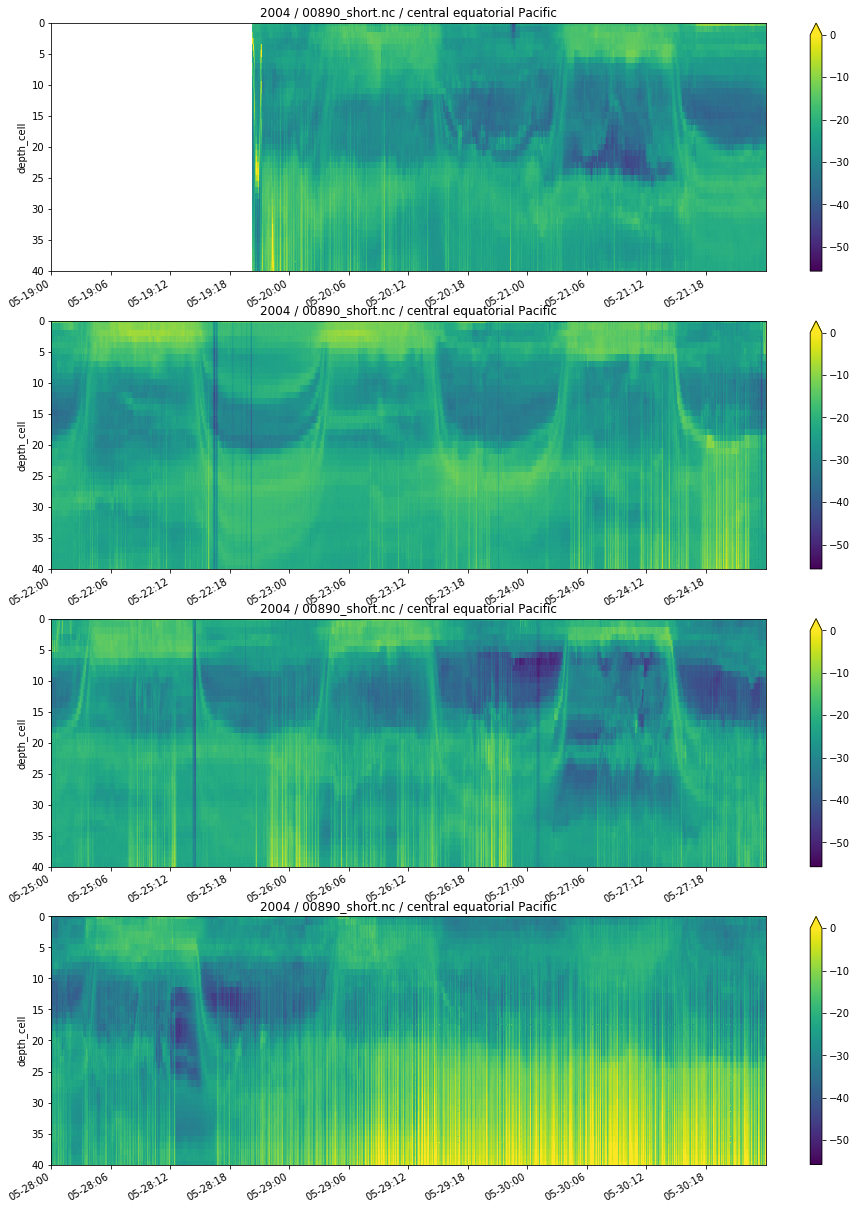

In [5]:
fig,axes = plt.subplots(nrows=4, ncols=1, figsize=(16,21))
daynum = 19
for isp in np.arange(0,4):
    Sv.plot(ax=axes[isp],y='depth_cell', vmax=0, yincrease=False)
    axes[isp].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
    axes[isp].set_xlim(['2004-05-'+str(daynum),'2004-05-'+str(daynum+3)])
    axes[isp].set_ylim([40,0])
    axes[isp].set_xticks(np.arange('2004-05-'+str(daynum), '2004-05-'+str(daynum+3), dtype='datetime64[h]')[0::6])
    #axes[isp].set_title(str(pd.to_datetime(Sv.time[0].values).year) + ', ' + fname)
    axes[isp].set_title(str(row['cruise_beg_date'].year) + ' / ' + fname + ' / ' + row['geo_region'])
    axes[isp].set_xlabel('')
    daynum = daynum + 3
#fig.savefig(figpath + os.path.splitext(fname)[0] + '_Sv.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

In [6]:
%%script false --no-raise-error
# include the line above if you don't want to run this cell
fig,axes = plt.subplots(nrows=4, ncols=1, figsize=(16,21))
daynum = 19
for isp in np.arange(0,4):
    Sv.plot(ax=axes[isp],y='depth_cell', vmax=0, yincrease=False)
    axes[isp].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
    axes[isp].set_xlim(['2004-05-'+str(daynum),'2004-05-'+str(daynum+3)])
    axes[isp].set_ylim([40,0])
    axes[isp].set_xticks(np.arange('2004-05-'+str(daynum), '2004-05-'+str(daynum+3), dtype='datetime64[h]')[0::6])
    #axes[isp].set_title(str(pd.to_datetime(Sv.time[0].values).year) + ', ' + fname)
    axes[isp].set_title(str(row['cruise_beg_date'].year) + ' / ' + fname + ' / ' + row['geo_region'])
    axes[isp].set_xlabel('')
    daynum = daynum + 3
#fig.savefig(figpath + os.path.splitext(fname)[0] + '_Sv.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

### Convert from UTC time to solar altitude/elevation, re-look at Sv w/ solar alt, then compute day/night avg Sv like in Bianchi et al. (2013)

In [8]:
from datetime import datetime
from datetime import time, timedelta
from math import pi, cos, sin, acos

In [14]:
# https://stackoverflow.com/questions/13314626/local-solar-time-function-from-utc-and-longitude
# https://www.esrl.noaa.gov/gmd/grad/solcalc/solareqns.PDF
def get_solar_time_and_angles(dt,longit,latit): 
    gamma = 2 * pi / 365 * (dt.timetuple().tm_yday - 1 + float(dt.hour - 12) / 24) # unit = radians
    eqtime = 229.18 * (0.000075 + 0.001868 * cos(gamma) - 0.032077 * sin(gamma) \
             - 0.014615 * cos(2 * gamma) - 0.040849 * sin(2 * gamma)) # unit = minutes
    decl = 0.006918 - 0.399912 * cos(gamma) + 0.070257 * sin(gamma) \
           - 0.006758 * cos(2 * gamma) + 0.000907 * sin(2 * gamma) \
           - 0.002697 * cos(3 * gamma) + 0.00148 * sin(3 * gamma) # unit = radians
    time_offset = eqtime + 4 * longit # unit = minutes
    tst = dt.hour * 60 + dt.minute + dt.second / 60 + time_offset # unit = minutes
    solar_time = datetime.combine(dt.date(), time(0)) + timedelta(minutes=tst) # unit = datetime
    solar_hour_angle = (tst/4) - 180 # unit = degrees
    solar_zenith_angle = 180/pi * acos(sin(latit*pi/180)*sin(decl) + \
                                       cos(latit*pi/180)*cos(decl)*cos(solar_hour_angle*pi/180)) # unit = degrees
    solar_alt_angle = 90 - solar_zenith_angle # unit = degrees
    #return solar_time, solar_hour_angle, solar_zenith_angle, solar_alt_angle
    return solar_time, solar_alt_angle

In [15]:
solar_time = [None]*len(Sv['time'])
solar_hour_angle = [None]*len(Sv['time'])
solar_zenith_angle = [None]*len(Sv['time'])
solar_alt_angle = [None]*len(Sv['time'])
print(datetime.now().strftime("%H:%M:%S"))
for itime in range(0,len(Sv['time'])):
    lon = float(nc['lon'][itime])
    lat = float(nc['lat'][itime])
    utc_time = pd.to_datetime(Sv.time.values[itime])
    #solar_time[itime], solar_hour_angle[itime], \
    #    solar_zenith_angle[itime], solar_alt_angle[itime] = \
    #    get_solar_time_and_angles(utc_time,lon,lat)
    solar_time[itime], solar_alt_angle[itime] = \
        get_solar_time_and_angles(utc_time,lon,lat)
print(datetime.now().strftime("%H:%M:%S"))

07:11:19
07:11:25


In [17]:
%%script false --no-raise-error
# - Check that solar_alt_angle = 90 = local solar noon ish, solar_alt_angle = -90 = local solar midnight ish
# --> Seems good!
plt.plot(solar_alt_angle)
plt.plot([t.hour for t in solar_time])
plt.ylim([-90,90])

### Copy Sv w/ local solar time + relook at new Sv

In [18]:
# --> Looks great! DSL is deepest at noon local solar time!
Svst = Sv.copy(deep=True)
Svst['time'] = solar_time

In [43]:
Svst_pf = nc['pflag'].copy(deep=True)
Svst_pf['time'] = solar_time

In [44]:
Svst_pg = nc['pg'].copy(deep=True)
Svst_pg['time'] = solar_time

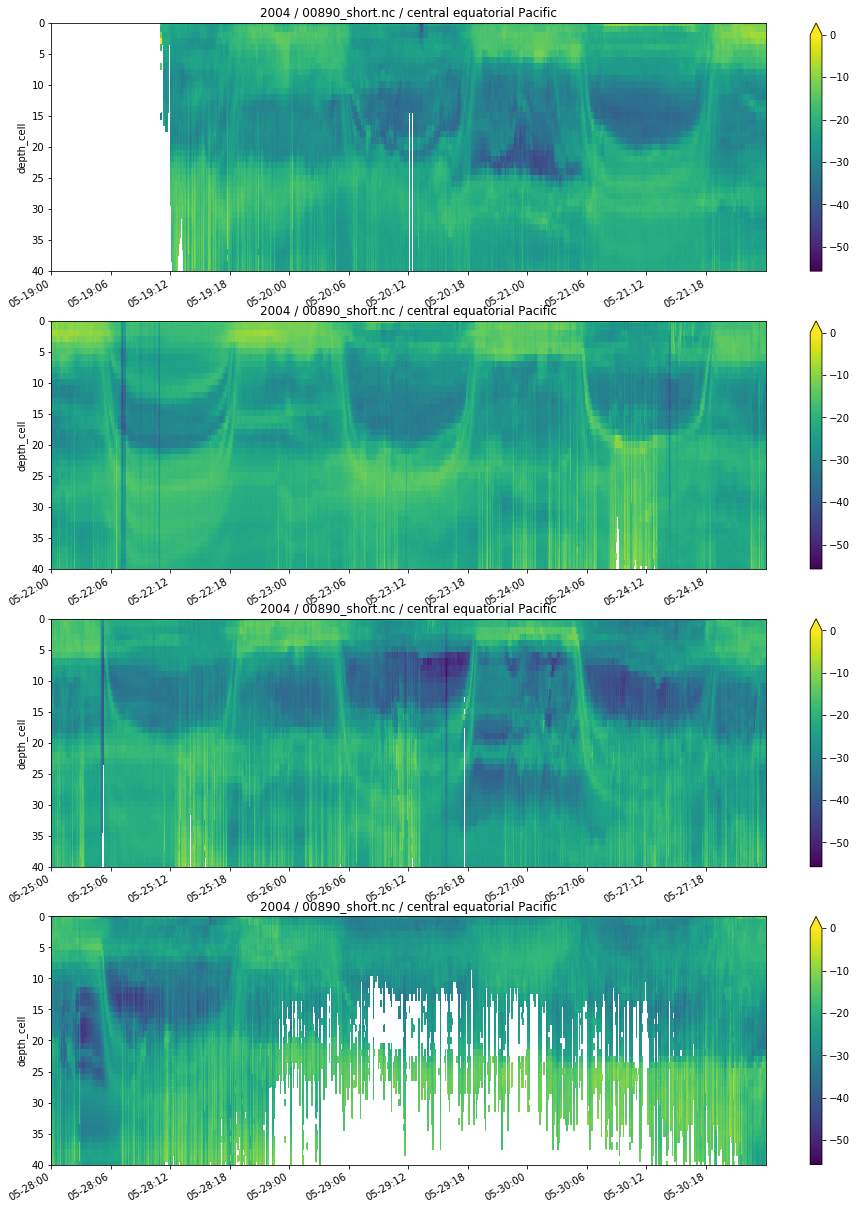

In [48]:
fig,axes = plt.subplots(nrows=4, ncols=1, figsize=(16,21))
daynum = 19
for isp in np.arange(0,4):
    Svst.where(Svst_pg>60).plot(ax=axes[isp],y='depth_cell', vmax=0, yincrease=False)
    axes[isp].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
    axes[isp].set_xlim(['2004-05-'+str(daynum),'2004-05-'+str(daynum+3)])
    axes[isp].set_ylim([40,0])
    axes[isp].set_xticks(np.arange('2004-05-'+str(daynum), '2004-05-'+str(daynum+3), dtype='datetime64[h]')[0::6])
    #axes[isp].set_title(str(pd.to_datetime(Sv.time[0].values).year) + ', ' + fname)
    axes[isp].set_title(str(row['cruise_beg_date'].year) + ' / ' + fname + ' / ' + row['geo_region'])
    axes[isp].set_xlabel('')
    daynum = daynum + 3
#fig.savefig(figpath + os.path.splitext(fname)[0] + '_Sv.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

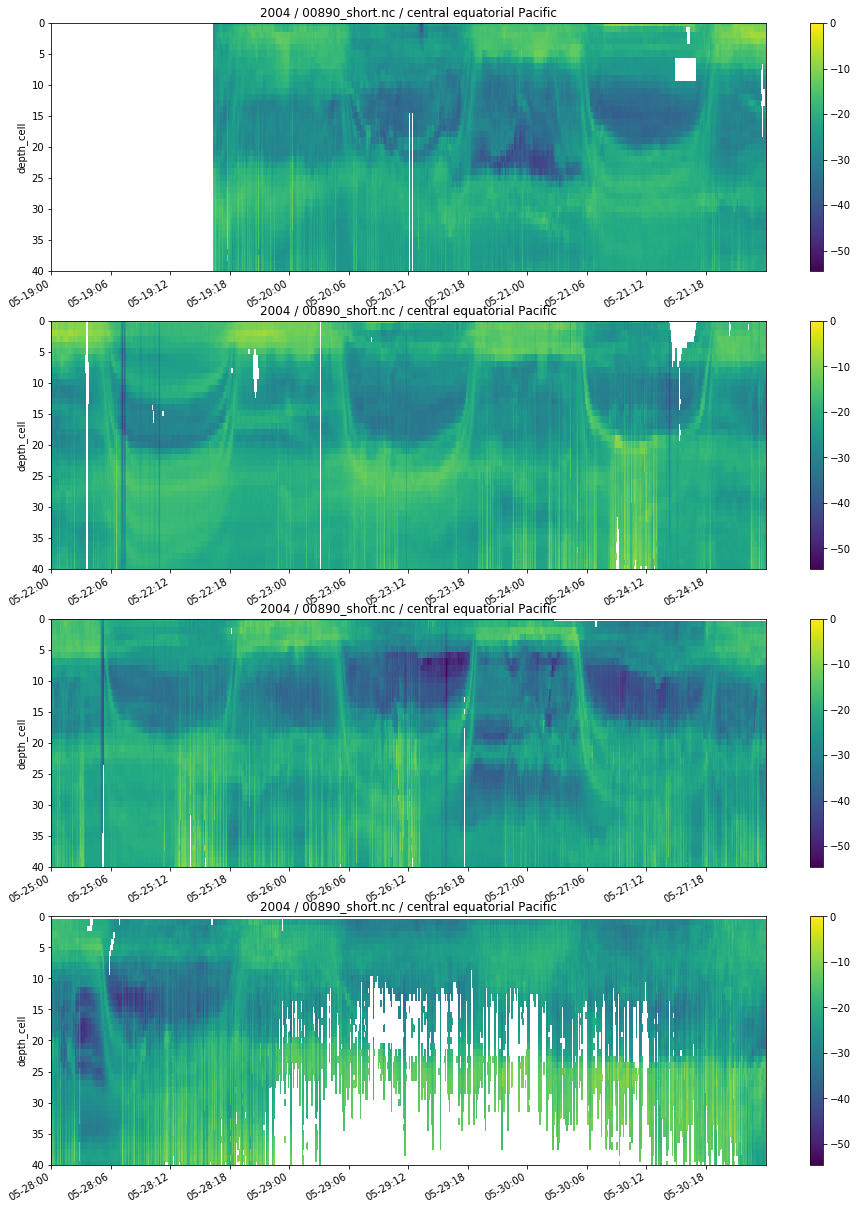

In [47]:
fig,axes = plt.subplots(nrows=4, ncols=1, figsize=(16,21))
daynum = 19
for isp in np.arange(0,4):
    Svst.where((Svst_pf==0) & (Svst_pg>60)).plot(ax=axes[isp],y='depth_cell', vmax=0, yincrease=False)
    axes[isp].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
    axes[isp].set_xlim(['2004-05-'+str(daynum),'2004-05-'+str(daynum+3)])
    axes[isp].set_ylim([40,0])
    axes[isp].set_xticks(np.arange('2004-05-'+str(daynum), '2004-05-'+str(daynum+3), dtype='datetime64[h]')[0::6])
    #axes[isp].set_title(str(pd.to_datetime(Sv.time[0].values).year) + ', ' + fname)
    axes[isp].set_title(str(row['cruise_beg_date'].year) + ' / ' + fname + ' / ' + row['geo_region'])
    axes[isp].set_xlabel('')
    daynum = daynum + 3
#fig.savefig(figpath + os.path.splitext(fname)[0] + '_Sv.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

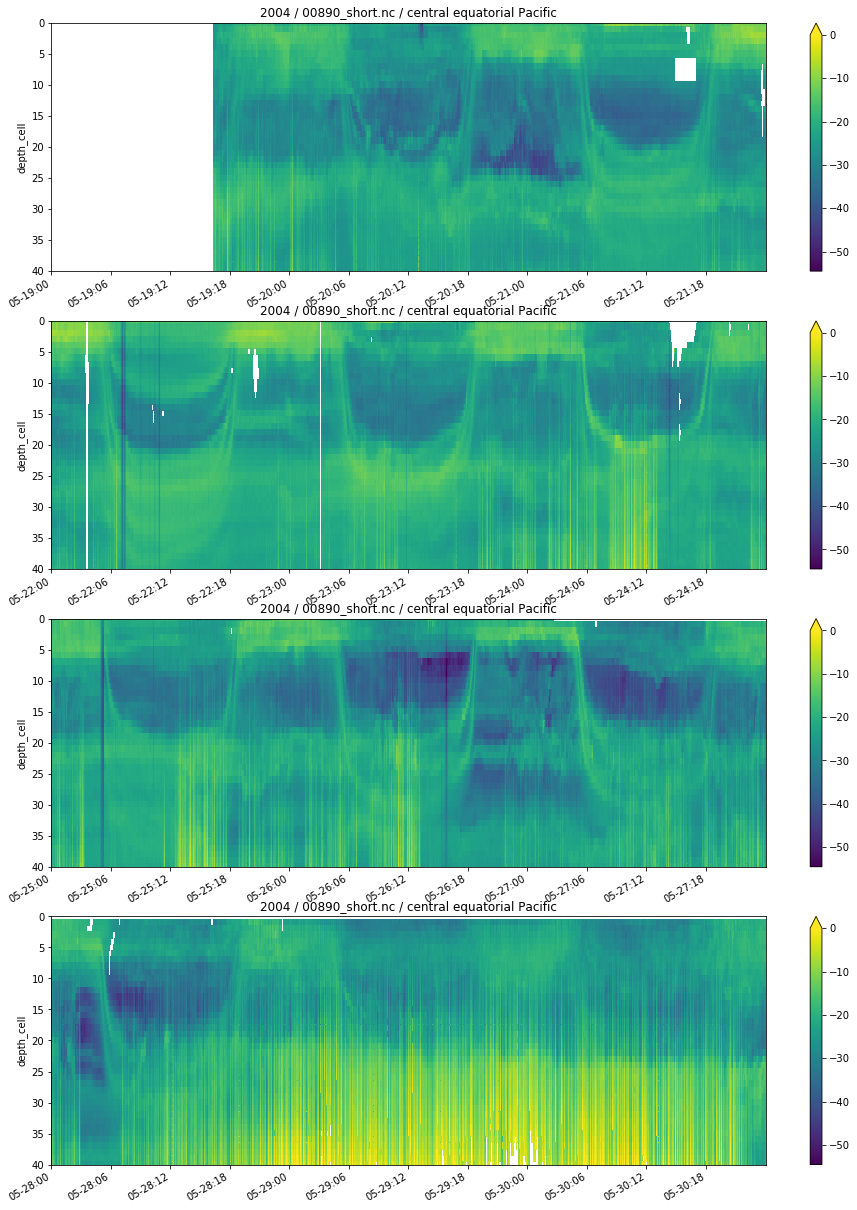

In [45]:
fig,axes = plt.subplots(nrows=4, ncols=1, figsize=(16,21))
daynum = 19
for isp in np.arange(0,4):
    Svst.where(Svst_pf==0).plot(ax=axes[isp],y='depth_cell', vmax=0, yincrease=False)
    axes[isp].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
    axes[isp].set_xlim(['2004-05-'+str(daynum),'2004-05-'+str(daynum+3)])
    axes[isp].set_ylim([40,0])
    axes[isp].set_xticks(np.arange('2004-05-'+str(daynum), '2004-05-'+str(daynum+3), dtype='datetime64[h]')[0::6])
    #axes[isp].set_title(str(pd.to_datetime(Sv.time[0].values).year) + ', ' + fname)
    axes[isp].set_title(str(row['cruise_beg_date'].year) + ' / ' + fname + ' / ' + row['geo_region'])
    axes[isp].set_xlabel('')
    daynum = daynum + 3
#fig.savefig(figpath + os.path.splitext(fname)[0] + '_Sv.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

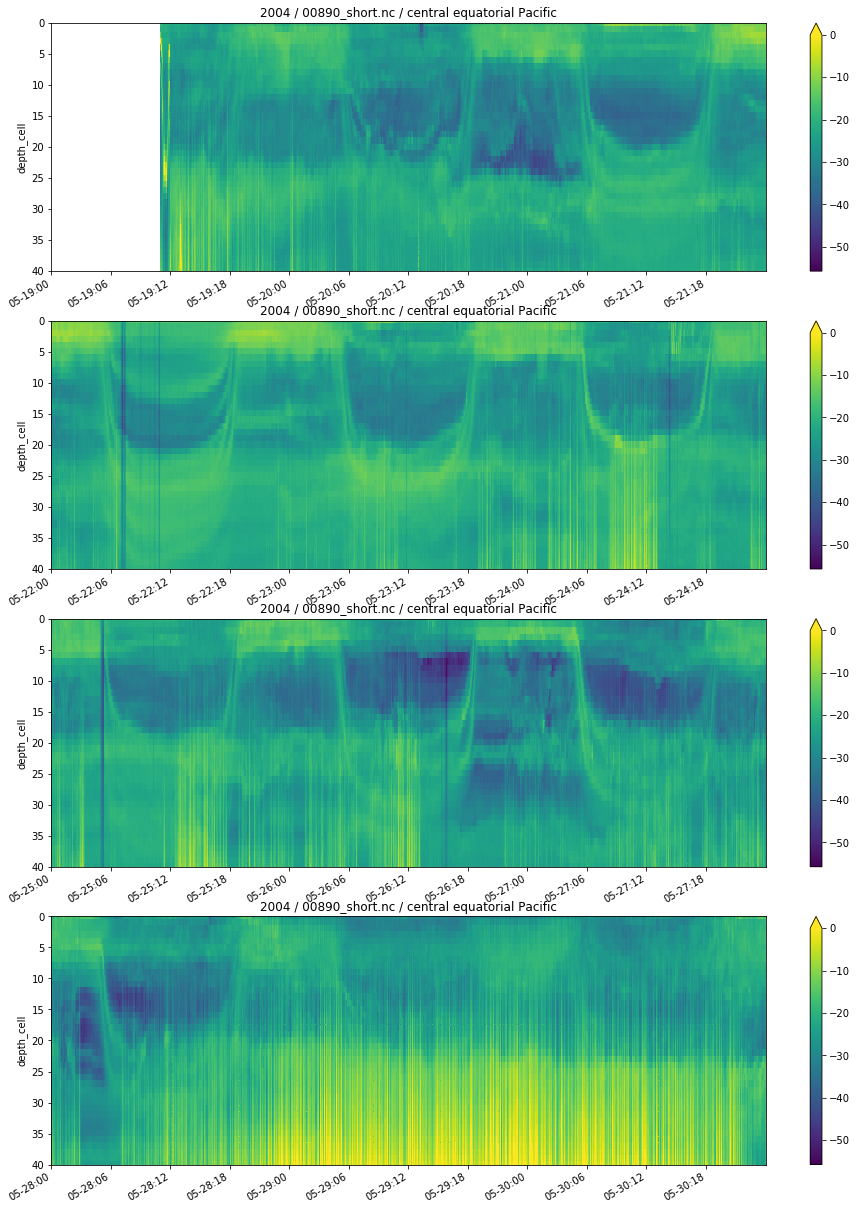

In [19]:
fig,axes = plt.subplots(nrows=4, ncols=1, figsize=(16,21))
daynum = 19
for isp in np.arange(0,4):
    Svst.plot(ax=axes[isp],y='depth_cell', vmax=0, yincrease=False)
    axes[isp].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
    axes[isp].set_xlim(['2004-05-'+str(daynum),'2004-05-'+str(daynum+3)])
    axes[isp].set_ylim([40,0])
    axes[isp].set_xticks(np.arange('2004-05-'+str(daynum), '2004-05-'+str(daynum+3), dtype='datetime64[h]')[0::6])
    #axes[isp].set_title(str(pd.to_datetime(Sv.time[0].values).year) + ', ' + fname)
    axes[isp].set_title(str(row['cruise_beg_date'].year) + ' / ' + fname + ' / ' + row['geo_region'])
    axes[isp].set_xlabel('')
    daynum = daynum + 3
#fig.savefig(figpath + os.path.splitext(fname)[0] + '_Sv.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

### Figure out alg to get DVM depth

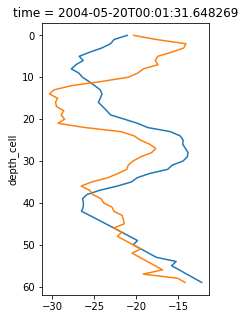

In [26]:
# - Look at noon compared to midnight profile for one day
fig,axes = plt.subplots(nrows=1, ncols=1, figsize=(3,5))
Svst.sel(time='2004-05-19T12:01:23').plot(ax=axes, y='depth_cell', yincrease=False)
Svst.sel(time='2004-05-20T00:01').plot(ax=axes, y='depth_cell', yincrease=False)

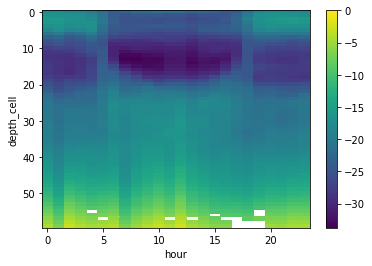

In [28]:
# - Look at hour climatology Sv over whole cruise
Svst_hr = Svst.groupby('time.hour').mean(dim='time')
Svst_hr.plot(y='depth_cell', yincrease=False, vmax=0)

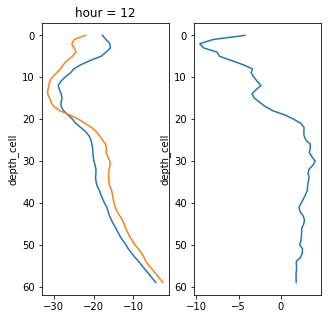

In [29]:
# - Look at difference in hour climatology Sv over whole cruise btwn noon and midnight
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(5,5))
Svst_hr.sel(hour=0).plot(ax=axes[0], y='depth_cell', yincrease=False) # blue
Svst_hr.sel(hour=12).plot(ax=axes[0], y='depth_cell', yincrease=False) # orange
Svst_hr_diff = Svst_hr.sel(hour=12)-Svst_hr.sel(hour=0)
Svst_hr_diff.plot(ax=axes[1], y='depth_cell', yincrease=False) # orange

In [31]:
print(Svst_hr.isel(depth_cell=range(0,35)).sel(hour=0).argmax())
print(Svst_hr.isel(depth_cell=range(0,35)).sel(hour=12).argmax())
#Svst_hr.sel(hour=12)
#Svst_hr_diff.isel(depth_cell=range(0,35)).sel(hour=12).argmax()
print(Svst_hr_diff.argmax())
Svst_hr_diff

<xarray.DataArray ()>
array(3)
Coordinates:
    hour     int64 0
<xarray.DataArray ()>
array(31)
Coordinates:
    hour     int64 12
<xarray.DataArray ()>
array(30)


<xarray.DataArray (depth_cell: 60)>
array([-4.24879965, -8.04981548, -9.59925235, -9.15776103, -7.56153   ,
       -7.25919107, -5.86238309, -4.48376154, -3.36980762, -3.52721641,
       -3.18441625, -2.80859863, -2.36481207, -2.9646132 , -3.43484759,
       -3.13305384, -2.51590756, -1.85161497, -0.95691554,  0.43470981,
        1.48549178,  2.35079756,  2.73262205,  2.70579844,  2.73326998,
        2.9613517 ,  3.46791458,  3.45840377,  3.35594426,  3.67062943,
        4.03797837,  3.79238337,  3.31139232,  3.21410673,  3.33043747,
        3.22205827,  3.14984874,  3.12325268,  2.90868107,  2.66899414,
        2.41293605,  2.13888539,  2.24704454,  2.58874029,  2.78758052,
        2.70168834,  2.46796764,  2.4403769 ,  2.42428226,  2.3721505 ,
        2.21567099,  2.55421069,  2.51394536,  2.32124789,  1.80686215,
        1.83753137,  1.83910006,  1.77730777,  1.7989096 ,  1.79890902])
Dimensions without coordinates: depth_cell

07:22:29
19
22
11
26
20
35
35
27
29
32
0
57
07:22:30


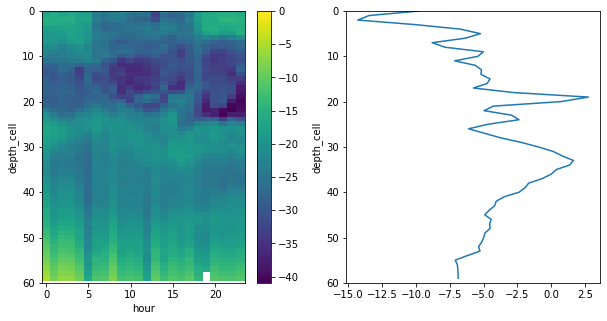

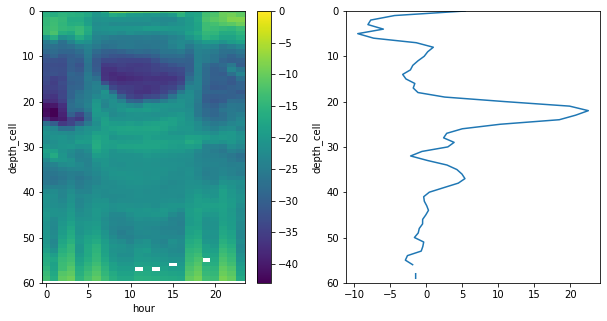

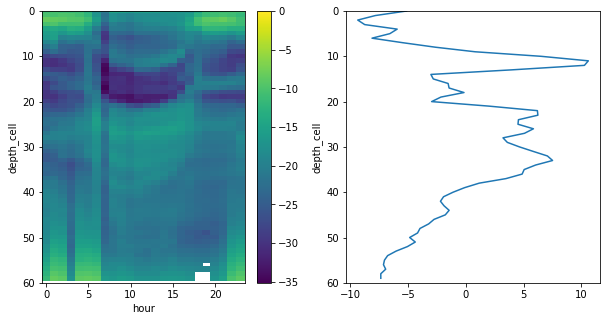

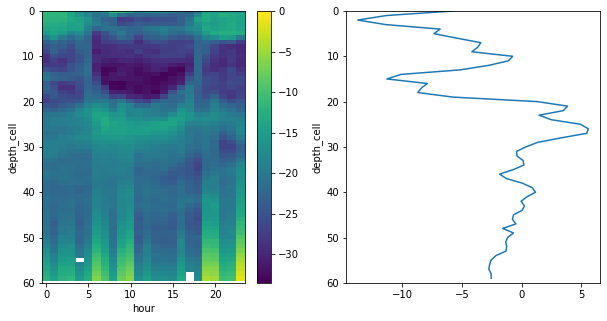

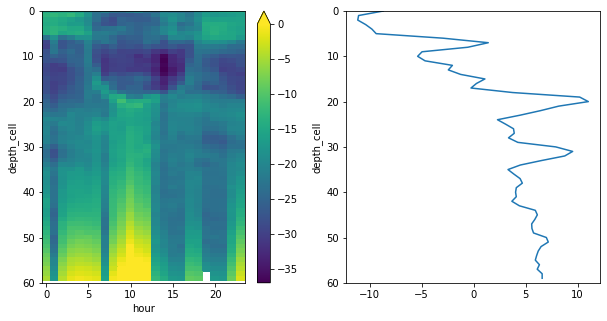

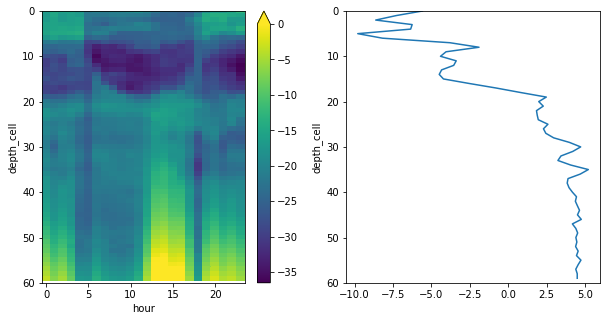

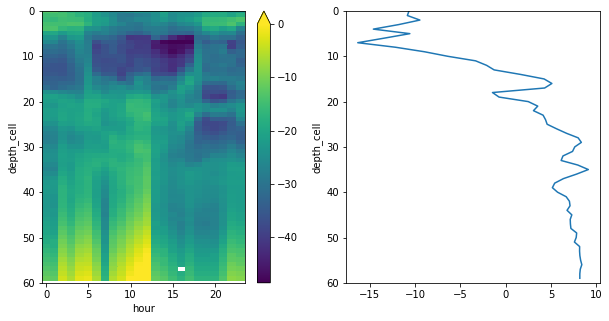

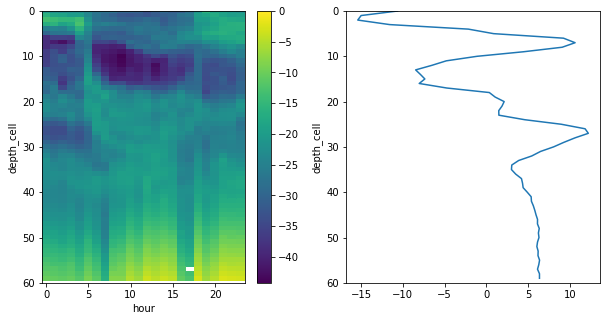

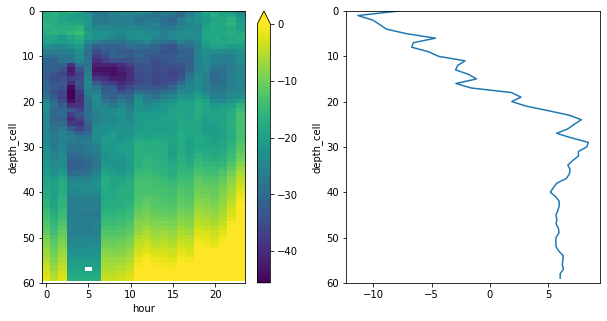

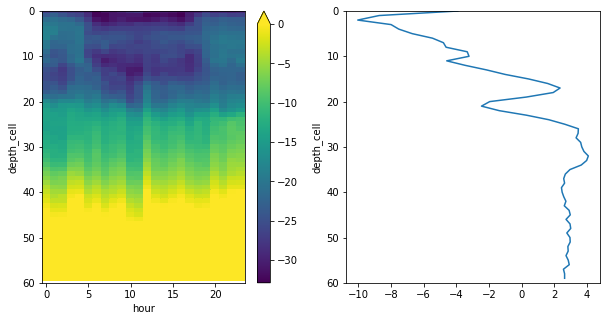

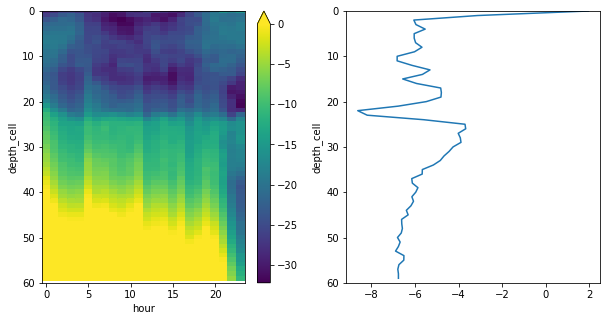

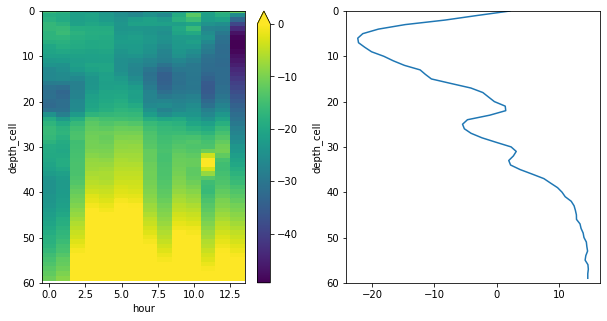

In [32]:
# - METHOD 1a: Find DVM depth w/ largest diff in Sv btwn noon+1hr and midnight+1hr
# (+1hr for ease of coding, -1hr can be added later)
# 1.) Calculate difference btwn hr 0 and hr 12 for each day 
# 2.) Find depth of maximum diff btwn hr 12 minus hr 0 --> DVM depth
print(datetime.now().strftime("%H:%M:%S"))
noon_hrs = [12,13] # noon hours 
midn_hrs = [0,1] # midnight hours
tot_cdays = (pd.to_datetime(Svst['time'][-1].values) - pd.to_datetime(Svst['time'][0].values)).days
dvm_depth_cell = [None]*tot_cdays
daynow = pd.to_datetime(Svst['time'][0].values)
for iday in range(0,tot_cdays):
    daynow = daynow + timedelta(days=1)
    day_strnow = daynow.strftime('%Y-%m-%d') 
    Svstnow = Svst.sel(time=day_strnow)
    Svst_hrnow = Svstnow.groupby('time.hour').mean(dim='time') 
    if (len(set(Svst_hrnow['hour'].values).intersection(midn_hrs))>0
       ) & (len(set(Svst_hrnow['hour'].values).intersection(noon_hrs))>0):
        Svst_diffnow = Svst_hrnow.sel(hour=noon_hrs).mean(dim='hour')-Svst_hrnow.sel(hour=midn_hrs).mean(dim='hour')
        dvm_depth_cell[iday] = int(Svst_diffnow.argmax())
    else:
        dvm_depth_cell[iday] = np.nan
    print(dvm_depth_cell[iday])
    fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    Svst_hrnow.plot(ax=axes[0], y='depth_cell', yincrease=False, ylim=[60,0], vmax=0)
    Svst_diffnow.plot(ax=axes[1], y='depth_cell', yincrease=False, ylim=[60,0])
print(datetime.now().strftime("%H:%M:%S"))

07:26:53
19
22
11
26
20
35
35
27
29
32
0
57
07:26:54


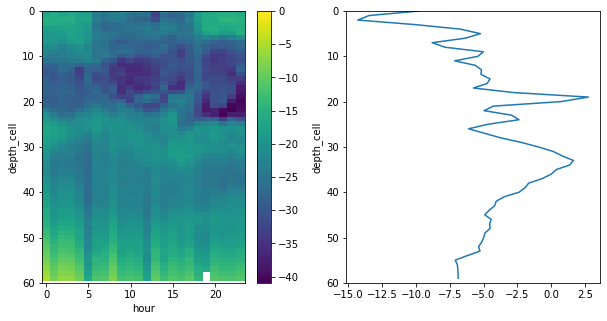

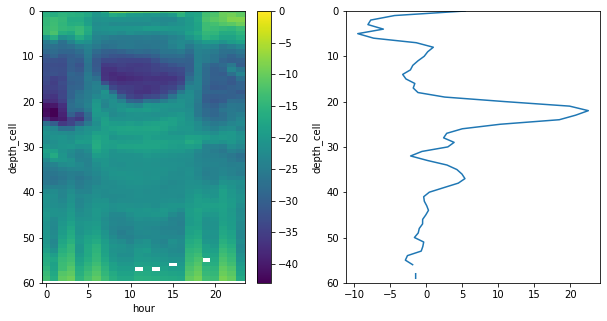

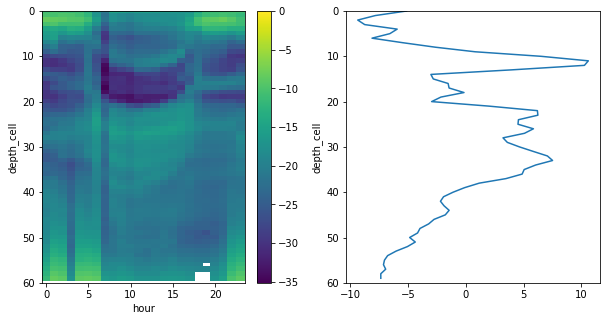

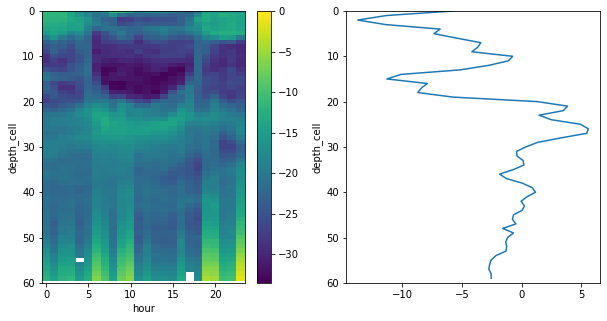

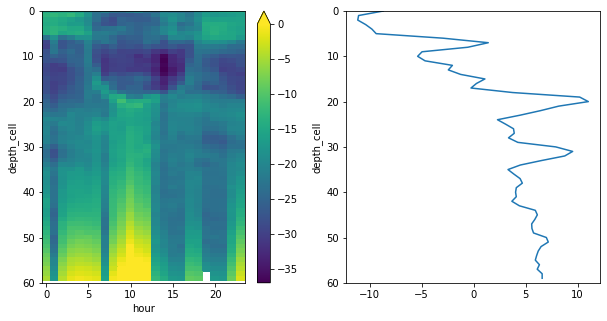

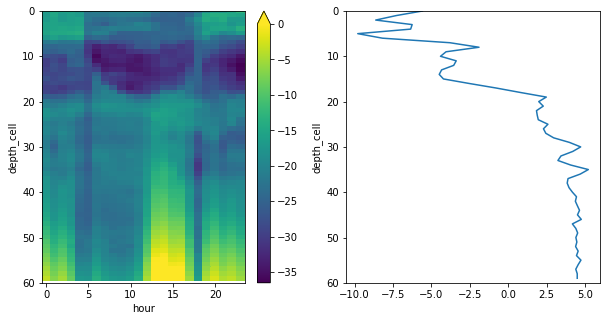

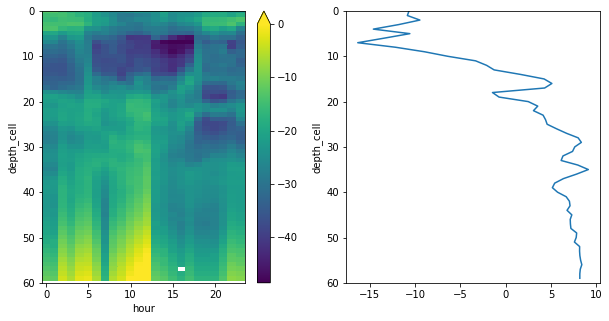

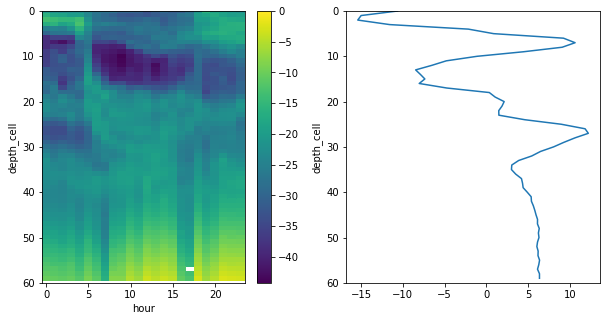

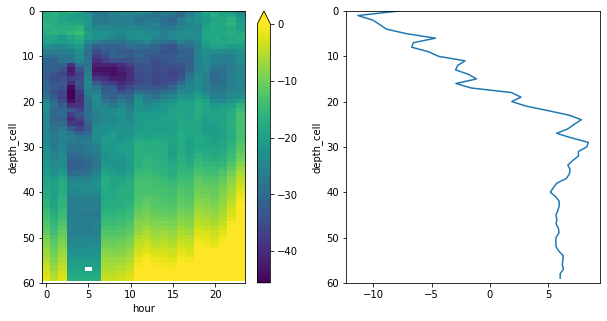

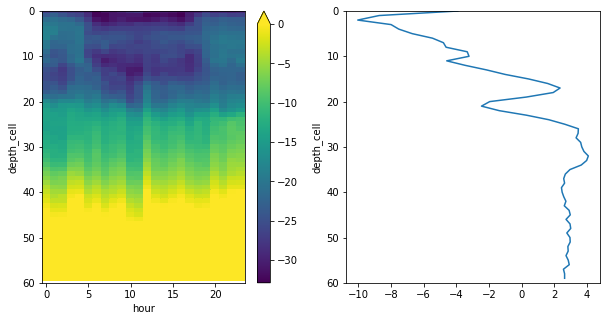

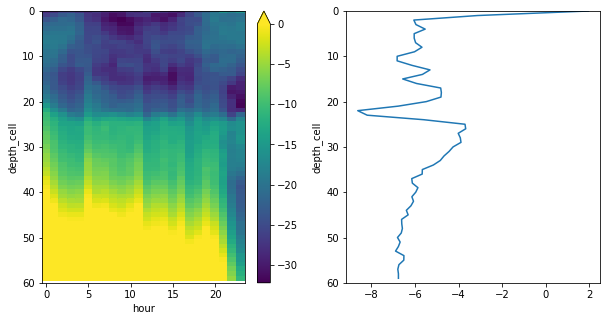

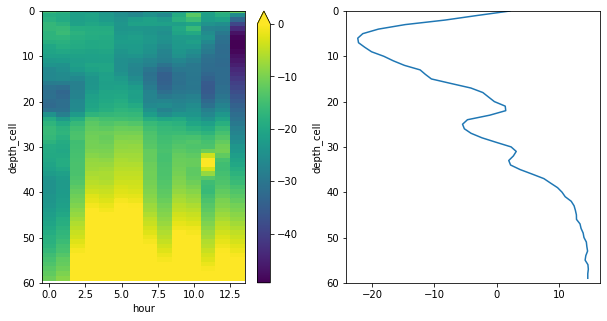

In [35]:
# - METHOD 1b: Find DVM depth w/ largest diff in Sv btwn noon and midnight
# 1.) Calculate difference btwn hr 0 and hr 12 for each day 
# 2.) Find depth of maximum diff btwn hr 12 minus hr 0 --> DVM depth
print(datetime.now().strftime("%H:%M:%S"))
noon_hrs = [12,13] # noon hours 
midn_hrs = [0,1] # midnight hours
tot_cdays = (pd.to_datetime(Svst['time'][-1].values) - pd.to_datetime(Svst['time'][0].values)).days
dvm_depth_cell = [None]*tot_cdays
daynow = pd.to_datetime(Svst['time'][0].values)
for iday in range(0,tot_cdays):
    daynow = daynow + timedelta(days=1)
    day_strnow = daynow.strftime('%Y-%m-%d') 
    Svstnow = Svst.sel(time=day_strnow)
    Svst_hrnow = Svstnow.groupby('time.hour').mean(dim='time') 
    if (len(set(Svst_hrnow['hour'].values).intersection(midn_hrs))>0
       ) & (len(set(Svst_hrnow['hour'].values).intersection(noon_hrs))>0):
        Svst_diffnow = Svst_hrnow.sel(hour=noon_hrs).mean(dim='hour')-Svst_hrnow.sel(hour=midn_hrs).mean(dim='hour')
        dvm_depth_cell[iday] = int(Svst_diffnow.argmax())
    else:
        dvm_depth_cell[iday] = np.nan
    print(dvm_depth_cell[iday])
    fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    Svst_hrnow.plot(ax=axes[0], y='depth_cell', yincrease=False, ylim=[60,0], vmax=0)
    Svst_diffnow.plot(ax=axes[1], y='depth_cell', yincrease=False, ylim=[60,0])
print(datetime.now().strftime("%H:%M:%S"))

In [ ]:
# - OTHER THINGS TO TRY: nan all pts larger than surface Sv at midnight,
# get rid of pflag bad pts, get rid of pg below a threshold pts
# - METHOD 1c: Find DVM depth w/ largest diff in Sv btwn noon and midnight
# 1.) Calculate difference btwn hr 0 and hr 12 for each day 
# 2.) Find depth of maximum diff btwn hr 12 minus hr 0 --> DVM depth
print(datetime.now().strftime("%H:%M:%S"))
noon_hrs = [12,13] # noon hours 
midn_hrs = [0,1] # midnight hours
tot_cdays = (pd.to_datetime(Svst['time'][-1].values) - pd.to_datetime(Svst['time'][0].values)).days
dvm_depth_cell = [None]*tot_cdays
daynow = pd.to_datetime(Svst['time'][0].values)
for iday in range(0,tot_cdays):
    daynow = daynow + timedelta(days=1)
    day_strnow = daynow.strftime('%Y-%m-%d') 
    Svstnow = Svst.sel(time=day_strnow)
    Svst_hrnow = Svstnow.groupby('time.hour').mean(dim='time') 
    if (len(set(Svst_hrnow['hour'].values).intersection(midn_hrs))>0
       ) & (len(set(Svst_hrnow['hour'].values).intersection(noon_hrs))>0):
        Svst_diffnow = Svst_hrnow.sel(hour=noon_hrs).mean(dim='hour')-Svst_hrnow.sel(hour=midn_hrs).mean(dim='hour')
        dvm_depth_cell[iday] = int(Svst_diffnow.argmax())
    else:
        dvm_depth_cell[iday] = np.nan
    print(dvm_depth_cell[iday])
    fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    Svst_hrnow.plot(ax=axes[0], y='depth_cell', yincrease=False, ylim=[60,0], vmax=0)
    Svst_diffnow.plot(ax=axes[1], y='depth_cell', yincrease=False, ylim=[60,0])
print(datetime.now().strftime("%H:%M:%S"))

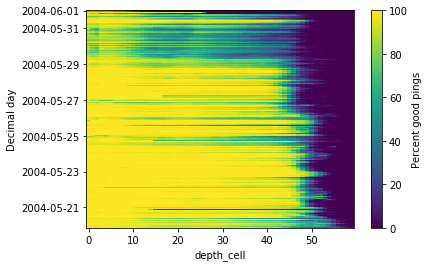

In [41]:
nc['pg'].plot()

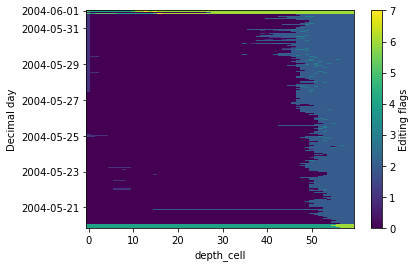

In [42]:
nc['pflag'].plot()

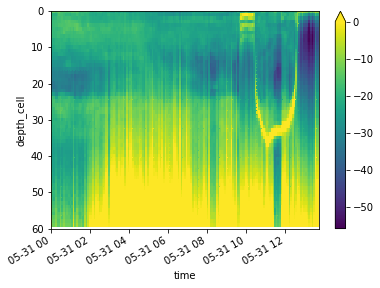

In [37]:
Svstnow.plot(y='depth_cell', yincrease=False, ylim=[60,0], vmax=0)

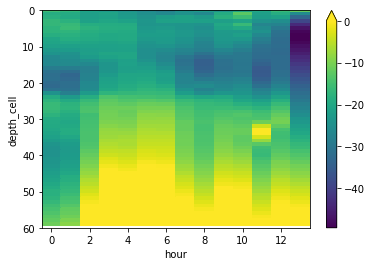

In [38]:
Svst_hrnow.plot(y='depth_cell', yincrease=False, ylim=[60,0], vmax=0)

# Compute Sv for all files assuming constant T, S, pH

In [ ]:
for fname in fnames:
    ncfile = dpath + 'JASADCP/ncfiles/' + fname
    nc = xr.open_dataset(ncfile)
    
    amp = nc['amp']
    Tx = nc['tr_temp']
    depth = nc['depth']
    row = df[df['fname']==fname].iloc[0]
    
    Er = get_Er_constant(row,amp)
    #print('Er: ',Er)
    
    if 'NB' not in row['instrument_name']:
        Kc = get_Kc_constant(row)
    elif 'NB' in row['instrument_name']:
        Kc = get_Kc_tdresolved(row,amp,Tx)
    #print('Kc: ',Kc)
    
    LDBM = get_LDBM_constant(row)
    #print('LDBM: ',LDBM)
    
    if 'NB' not in row['instrument_name']:
        PDBW = get_PDBW_constant(row)
    elif 'NB' in row['instrument_name']:
        #PDBW = get_PDBW_tdresolved(row)
        PDBW = get_PDBW_constant(row)
    #print('PDBW: ',PDBW)
    
    R = get_R_tdresolved(row, depth, method_num=5)
    #print('R: ',R)
    
    c = calc_c_tdresolved(depth,T=25,S=35)
    #print('c: ',c)
    
    if 'NB' not in row['instrument_name']:
        C = get_C_constant(row)
    elif 'NB' in row['instrument_name']:
        C = get_C_tdresolved(row,c)
    #print('C: ',C)
    
    Tnow = depth; Tnow.name = 'temperature'; Tnow[:,:] = 25
    alpha = calc_alpha_tdresolved(row,depth,c,Tnow,S=35,pH=8.1)
    #print('alpha: ',alpha)
    
    alphaR = calc_alphaR_tdresolved(alpha,R)
    #print('alphaR: ',alphaR)

    Sv = C + 10*np.log10((Tx+273.16)*R**2) - LDBM + PDBW \
        + 2*alphaR + 10*np.log10(10**(Kc*(amp-Er)/10) - 1)

    # - CONTINUE HERE!!!
    # - ADD DANIELE ALGORITHM

From Bianchi et al. (2013) supplementary info:

"For each detectable DVM event (4640 in total) we estimated the daytime DVM depth from:
- (1) the maximum subsurface day-to-night echo intensity difference, and
- (2) the maximum subsurface daytime backscatter.

In the first case we calculated the difference in ADCP echo intensity averaged over a 3-hour interval centered at the time of maximum solar elevation (midday) and the ADCP echo intensity averaged over a 3-hour interval centered at the time of minimum solar elevation (midnight) for the nights surrounding the DVM event. We then detected the depth of the maximum subsurface echo intensity difference.

In the second case, we estimated the depth of the midday subsurface backscatter maximum. Backscatter was estimated from the ADCP echo intensity by correcting for both sound-wave spherical attenuation and water absorption using the formulation of [Deines, 1999]. The use of the two methods increased the number of records for which the daytime DVM depth could be isolated. Whenever both methods provided a valid daytime DVM depth, the average of the two values was taken."


# Load WOD data (T,S)

# OLD

In [ ]:
daynum = 19
fig,axes = plt.subplots(nrows=1, ncols=1, figsize=(16,3))
Sv_orig.isel(depth_cell=0).plot(ax=axes)
Sv_lt.isel(depth_cell=0).plot(ax=axes)
axes.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
axes.set_ylim([-80,0])
axes.set_xlim(['2004-05-'+str(daynum),'2004-05-'+str(daynum+8)])
axes.set_xticks(np.arange('2004-05-'+str(daynum), '2004-05-'+str(daynum+8), dtype='datetime64[h]')[0::6]);

### Convert from UTC time to local time

In [ ]:
from datetime import datetime
from dateutil import tz
import pytz

In [ ]:
# - CONVERSION FROM UTC TO LOCAL TIME: METHOD 1 (same as METHOD 2)
# https://stackoverflow.com/questions/4563272/convert-a-python-utc-datetime-to-a-local-datetime-using-only-python-standard-lib
# answer by Lennart Regebro
now = datetime.utcnow()
#HERE = tz.tzlocal()
HERE = tz.gettz('America/New_York')
UTC = tz.gettz('UTC')
gmt = now.replace(tzinfo=UTC)
test = gmt.astimezone(HERE)
print(test)
print(test.year)
print(test.hour)

In [ ]:
# - CONVERSION FROM UTC TO LOCAL TIME: METHOD 2 (same as METHOD 1)
# https://stackoverflow.com/questions/4770297/convert-utc-datetime-string-to-local-datetime
# USE 1: Hardcode zones:
from_zone = tz.gettz('UTC')
to_zone = tz.gettz('America/New_York')
# USE 2: Auto-detect zones:
#from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
# utc = datetime.utcnow()
utc = datetime.strptime('2011-01-21 02:37:21', '%Y-%m-%d %H:%M:%S')
# Tell the datetime object that it's in UTC time zone since 
# datetime objects are 'naive' by default
utc = utc.replace(tzinfo=from_zone)
# Convert time zone
test = utc.astimezone(to_zone)
print(test)
print(test.year)
print(test.hour)

In [ ]:
# - MY USE OF METHODS 1 AND 2
test = pd.to_datetime(Sv.time.values[0]).replace(tzinfo=tz.gettz('UTC')).astimezone(tz.gettz('America/New_York'))
print(test)
print(test.year)
print(test.hour)

In [ ]:
# - CONVERSION FROM UTC TO LOCAL TIME: METHOD 3
# https://stackoverflow.com/questions/25264811/pytz-converting-utc-and-timezone-to-local-time
pytz.utc.localize(datetime.utcnow()).astimezone(tz.gettz('America/New_York'))

In [ ]:
# - MY USE OF METHOD 3
test = pytz.utc.localize(pd.to_datetime(Sv.time.values[0])).astimezone(tz.gettz('America/New_York'))
print(test)
print(test.year)
print(test.hour)

In [ ]:
# - CONVERSION FROM UTC TO LOCAL TIME: METHOD 4
# https://stackoverflow.com/questions/25264811/pytz-converting-utc-and-timezone-to-local-time
# combines answers by N Randhawa and user8808265 
utc_time = datetime.strptime('2011-01-21 02:37:21', '%Y-%m-%d %H:%M:%S')
tznow = pytz.timezone('America/New_York')
tznow.fromutc(utc_time)

In [ ]:
# - MY USE OF METHOD 4
tznow = pytz.timezone('America/New_York')
test = tznow.fromutc(pd.to_datetime(Sv.time.values[0]))
print(test)
print(test.year)
print(test.hour)

In [ ]:
# - Now need to find time zone from lat/lon, then apply METHOD 4 above

# https://pypi.org/project/timezonefinder/
from timezonefinder import TimezoneFinder
tf = TimezoneFinder()
#print(timezonefinder.__file__)

latitude, longitude = 52.5061, 13.358
tzstr = tf.timezone_at(lng=longitude, lat=latitude) # returns 'Europe/Berlin'
tznow = pytz.timezone(tzstr)
utc_time = datetime.strptime('2011-01-21 02:37:21', '%Y-%m-%d %H:%M:%S')
#test = tznow.fromutc(pd.to_datetime(Sv.time.values[0]))
test = tznow.fromutc(utc_time)
print(test)
print(test.year)
print(test.hour)

latitude, longitude = float(nc['lat'][0]), float(nc['lon'][0])
tzstr = tf.timezone_at(lng=longitude, lat=latitude)
print(tzstr)
tznow = pytz.timezone(tzstr)
utc_time = datetime.strptime('2011-01-21 02:37:21', '%Y-%m-%d %H:%M:%S')
#test = tznow.fromutc(pd.to_datetime(Sv.time.values[0]))
test = tznow.fromutc(utc_time)
print(test)
print(test.year)
print(test.hour)

In [ ]:
# - FINDING TIMEZONE FROM LAT/LON: METHOD 1
# (assuming timezone_at always works)
# --> sometimes timezone_at didn't work

local_time = [None]*len(Sv['time'])
print(datetime.now().strftime("%H:%M:%S"))
for itime in range(0,len(Sv['time'])):
    tzstr_worked = tf.timezone_at(lng=float(nc['lon'][itime]), lat=float(nc['lat'][itime]))
    tznow = pytz.timezone(tzstr_worked)
    local_time[itime] = tznow.fromutc(pd.to_datetime(Sv.time.values[itime]))
print(datetime.now().strftime("%H:%M:%S"))

In [ ]:
# - FINDING TIMEZONE FROM LAT/LON: METHOD 2
# (using out of box timezonefinder package before DLing new ocn timezones geojson)
# --> sometimes even closest_timezone_at didn't work b/c middle of Pac ocean lol and you don't
# really wanna set the search radius to like 40 deg lol

local_time = [None]*len(Sv['time'])
print(datetime.now().strftime("%H:%M:%S"))
for itime in range(0,len(Sv['time'])):
    tzstr = tf.timezone_at(lng=float(nc['lon'][itime]), lat=float(nc['lat'][itime]))
    search_rad = 1
    while tzstr==None:
        tzstr = tf.closest_timezone_at(lng=float(nc['lon'][itime]), lat=float(nc['lat'][itime]), delta_degree=search_rad)
        search_rad += 1
    #print(itime, tzstr, search_rad)
    tznow = pytz.timezone(tzstr)
    local_time[itime] = tznow.fromutc(pd.to_datetime(Sv.time.values[itime]))
print(datetime.now().strftime("%H:%M:%S"))

In [ ]:
# - FINDING TIMEZONE FROM LAT/LON: METHOD 3
# https://timezonefinder.readthedocs.io/en/latest/2_use_cases.html 
# --> I did the procedure under "Use other data" section for getting better ocn timezone coverage
# By golly,  it was a nightmare/mess. Check Dockerfile for all the steps needed to make this work.
# But I think it works now! Either every ocn lat/lon has a timezone OR we deal with closest_timezone_at
# still not working by getting the last lat/lon timezone that worked. Since a cruise is a cruise (i.e.,
# you travel from one pt to another continuously and pts are all next to each other), this should be a good
# approximation. Plus, you can check it with local_time_flag and local_time_search_rad

local_time = [None]*len(Sv['time'])
local_time_flag = [None]*len(Sv['time'])
tz_search_rad = [None]*len(Sv['time'])
tz_name = [None]*len(Sv['time'])

print(datetime.now().strftime("%H:%M:%S"))
for itime in range(0,len(Sv['time'])):
    search_rad = 0
    lon = float(nc['lon'][itime])
    lat = float(nc['lat'][itime]) 
    try:
        tzstr_worked = tf.timezone_at(lng=lon, lat=lat)
        tznow = pytz.timezone(tzstr_worked)
        tz_name[itime] = tzstr_worked
    except: 
        tzstr = None
        search_rad = 1
        while tzstr is None:
            try:
                tzstr = tf.closest_timezone_at(lng=lon, lat=lat, delta_degree=search_rad)
            except: 
                if search_rad<5:
                    search_rad = search_rad + 1
                elif (search_rad>=5) & (search<=10):
                    search_rad = search_rad + 5
                elif search_rad>10:
                    # gets the last tzstr that worked
                    tzstr = tzstr_worked
                    local_time_flag[itime] = 'grabbed last working tz'
        tznow = pytz.timezone(tzstr)
        tz_name[itime] = tzstr
    local_time[itime] = tznow.fromutc(pd.to_datetime(Sv.time.values[itime])).tz_localize(None)
    tz_search_rad[itime] = search_rad
    #print(itime, tzstr, search_rad)
print(datetime.now().strftime("%H:%M:%S"))

In [ ]:
# - Create unchangeable copy of the orig Sv
Sv_orig = Sv.copy(deep=True)

In [ ]:
%%scrip

In [ ]:
t false --no-raise-error
# include the line above if you don't want to run this cell

# - Replot Sv w/ new local times
# --> problems w/ plotting Sv_lt b/c of non-monotonic times
# --> error = "The input coordinate is not sorted in increasing order along axis 0.
# This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray."
Sv_lt = Sv_orig.copy(deep=True)
Sv_lt['time'] = local_time
#Sv_lt.plot()

# - Is the problem that I should just change time values rather than encoding/attrs?
# --> No, I don't think so...make sure the attrs data_min and data_max have correct new #s
Sv_lt = Sv_orig.copy(deep=True)
Sv_lt['time'].values = local_time
#Sv_lt.plot()
#print(Sv_lt['time'])

# - Do I just get floats (num of secs) if I remove time encoding?
# --> no
Sv_exp = Sv_orig.copy(deep=True)
Sv_exp['time'].encoding = {}
#print(Sv_exp['time'])

# - Compare Sv_orig['time'] and Sv['time']
# --> looks good w/ either Sv_lt['time'] = local_time or Sv_lt['time'].values = local_time
print(Sv_orig['time'][0])
print(Sv_orig['time'].attrs)
print(Sv_orig['time'].encoding)
print(Sv_lt['time'][0])
print(Sv_lt['time'].attrs)
print(Sv_lt['time'].encoding)

# - Continue to figure out why local_time gets out of order w/ non-monotonic times
# --> Looks like there are offsets of 10 and 11 hrs, instead of 9,
# for the times that go non-monotonic;
# http://www.geosats.com/timezmap.html - this map shows that 9, 10, 11 hrs offsets are correct
# for the given longitudes shown in dfprobno[sl!=0] below
# --> Let's use solar time to calculate day/night Sv instead!!!
# --> For visualization of time series, stick to utc!!!
import operator
ltnow = sorted(local_time)
map_object = map(operator.sub, ltnow, local_time)
subtracted_list = list(map_object)
sl = np.asarray([t.total_seconds() for t in subtracted_list]) # converts from deltatime to seconds
#print(sl[sl!=0])
#print(sl!=0)
#print(np.where(sl!=0))
dfprobno = pd.concat([pd.Series(ltnow,name='ltsort'), pd.Series(local_time,name='lt'),
                    pd.Series(Sv_orig['time'],name='utc'), pd.Series(local_time_flag, name='lt_flag'),
                    pd.Series(tz_search_rad,name='search_rad'),pd.Series(tz_name,name='tz'),
                    pd.Series(sl,name='sl')],axis=1)
dfprobno['u-lt'] = dfprobno['utc']-dfprobno['lt']
dfprobno['lon'] = pd.Series(nc['lon'],name='lon')
dfprobno['lat'] = pd.Series(nc['lat'],name='lat')
print(dfprobno[2300:2308]) # not messed up times
#dfprobno[2300:2308]
print(dfprobno[sl!=0]) # times where sorted(local_time) and local_time differ = messed up times
#dfprobno[sl!=0]

### Convert from UTC time to local solar time

In [10]:
# - CONVERSION FROM UTC TO SOLAR TIME: METHOD 1
# https://stackoverflow.com/questions/39163549/pyephem-calculate-current-solar-time
from ephem import Sun, Observer, pi, hours

dt = '2016/08/27 19:19'

sun = Sun()
sun.compute(dt)

boston = Observer()
boston.lat = '42.37'
boston.lon = '-71.03'
boston.date = dt
ra, dec = boston.radec_of('0', '-90')

print('Sun right ascension:', sun.ra)
print('Boston nadir right ascension:', ra)
print('Solar time:', hours((ra - sun.ra) % (2 * pi)), 'hours')

Sun right ascension: 10:27:05.16
Boston nadir right ascension: 0:59:55.01
Solar time: 14:32:49.85 hours


In [30]:
# - MY USE OF METHOD 1
solar_time = [None]*len(Sv['time'])
print(datetime.datetime.now().strftime("%H:%M:%S"))
for itime in range(0,len(Sv['time'])):
    utc_time = pd.to_datetime(Sv.time.values[itime])
    sun = Sun() 
    sun.compute(utc_time)
    loca = Observer()
    loca.lon = float(nc['lon'][itime])
    loca.lat = float(nc['lat'][itime])
    loca.date = utc_time
    ra, dec = loca.radec_of('0', '-90')
    solar_time[itime] = hours((ra - sun.ra) % (2 * pi))
print(datetime.datetime.now().strftime("%H:%M:%S"))

04:44:19
04:44:24


<class 'ephem.Angle'>


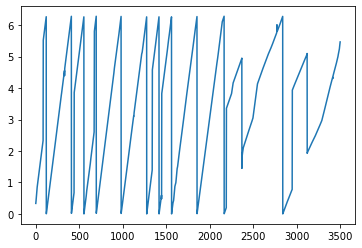

In [31]:
plt.plot(solar_time)
print(type(solar_time[0]))

In [27]:
# - CONVERSION FROM UTC TO SOLAR TIME: METHOD 2
# https://stackoverflow.com/questions/13314626/local-solar-time-function-from-utc-and-longitude
import ephem
def solartime(observer, sun=ephem.Sun()):
    sun.compute(observer)
    # sidereal time == ra (right ascension) is the highest point (noon)
    hour_angle = observer.sidereal_time() - sun.ra
    return ephem.hours(hour_angle + ephem.hours('12:00')).norm  # norm for 24h

In [33]:
import math
from datetime import timedelta
def ul_time(observer):
    utc_dt = observer.date.datetime()
    longitude = observer.long
    return utc_dt + timedelta(hours=longitude / math.pi * 12)

In [146]:
# - MY USE OF METHOD 2
local_time = [None]*len(Sv['time'])
solar_hour_angle = [None]*len(Sv['time'])
solar_time = [None]*len(Sv['time'])
print(datetime.datetime.now().strftime("%H:%M:%S"))
for itime in range(0,len(Sv['time'])):
    utc_time = pd.to_datetime(Sv.time.values[itime])
    observer = Observer()
    observer.lon = math.radians(float(nc['lon'][itime]))
    observer.lat = math.radians(float(nc['lat'][itime]))
    observer.date = utc_time
    solar_hour_angle[itime] = solartime(observer) 
    local_time[itime] = ul_time(observer)
    # convert hour angle to timedelta from noon
    ha = math.degrees(solar_hour_angle[itime])
    days = ha / 360
    td = timedelta(days=days)
    # make solar time
    solar_time[itime] = datetime.datetime.combine(local_time[itime].date(), datetime.time(0)) + td
print(datetime.datetime.now().strftime("%H:%M:%S"))

05:34:21
05:34:27


<class 'datetime.datetime'>


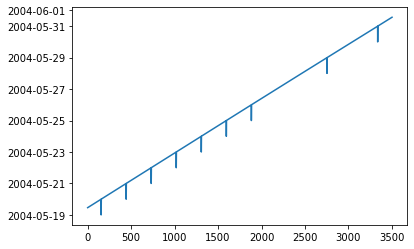

In [147]:
plt.plot(solar_time)
print(type(solar_time[0]))

<class 'datetime.datetime'>


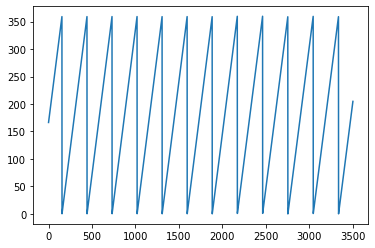

In [149]:
plt.plot([math.degrees(t) for t in solar_hour_angle])
print(type(solar_time[0]))

In [151]:
print(Sv['time'][0])
print(local_time[0])
print(solar_time[0])
print(solar_hour_angle[0])
solar_hour_angle[0]

<xarray.DataArray 'time' ()>
array('2004-05-19T20:22:29.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2004-05-19T20:22:29
Attributes:
    long_name:      Decimal day
    C_format:       %12.5f
    standard_name:  time
    data_min:       139.84894675925926
    data_max:       152.00609953703704
2004-05-19 11:02:04.491999
2004-05-19 11:05:35.198841
11:05:35.20


2.904169613410415

In [155]:
Svlthrs = np.asarray([int(t.strftime('%H')) for t in local_time])
Svuthrs = np.asarray([int(t.strftime('%H')) for t in pd.to_datetime(Sv['time'].values)])
stnp = np.asarray([int(t.strftime('%H')) for t in solar_time])

In [159]:
np.unique(stnp - Svlthrs)

array([-23,   0,   1])

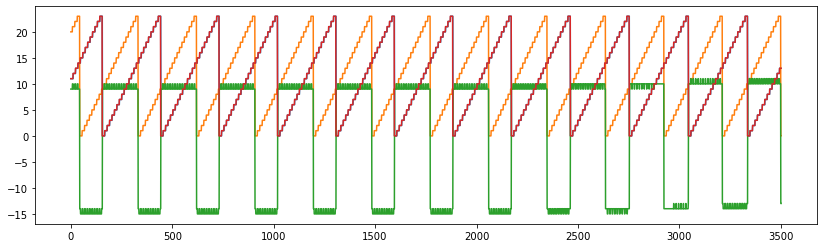

In [157]:
plt.figure(figsize=(14,4))
plt.plot(Svlthrs) # blue
plt.plot(Svuthrs) # orange
plt.plot(Svuthrs-Svlthrs) # green 
plt.plot(stnp) # red

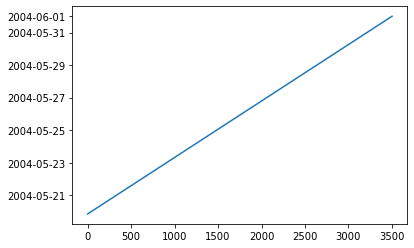

In [67]:
plt.plot(Sv['time'])

### Convert from UTC time to solar altitude/elevation, re-look at Sv w/ solar alt, then compute day/night avg Sv like in Bianchi et al. (2013)

In [7]:
# - CONVERSION FROM UTC TO SOLAR ALTITUDE: METHOD 1
# https://stackoverflow.com/questions/47663082/how-can-we-compute-solar-position-at-a-given-place-on-a-given-day-and-time
import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u

loc = coord.EarthLocation(lon=0.1 * u.deg, lat=51.5 * u.deg)
now = Time.now()
altaz = coord.AltAz(location=loc, obstime=now)
sun = coord.get_sun(now)
print(sun.transform_to(altaz).alt.degree)
# OR:
sun_time = Time('2017-12-6 17:00') #UTC time
loc = coord.EarthLocation.of_address('Baltimore, MD')  # anything the google geocoding API resolves
altaz = coord.AltAz(obstime=sun_time, location=loc)
print(coord.get_sun(sun_time).transform_to(altaz).alt.degree)

-3.006717787250207
28.139481919676243


In [8]:
from datetime import datetime
from datetime import time, timedelta
from math import pi, cos, sin, acos

In [12]:
# https://stackoverflow.com/questions/13314626/local-solar-time-function-from-utc-and-longitude
def approx_local_time(utc_time, longit):
    # utc_time should be a datetime obj, longit should be in degrees
    return utc_time+timedelta(hours=(longit*12/180))

In [ ]:
# - MY USE OF METHOD 1
sun_alt = [None]*len(Sv['time'])
local_time = [None]*len(Sv['time'])
print(datetime.now().strftime("%H:%M:%S"))
for itime in range(0,len(Sv['time'])):
    lon = nc['lon'][itime]
    lat = nc['lat'][itime]
    utc_time = Time(Sv.time.values[itime])
    loc = coord.EarthLocation(lon=lon*u.deg, lat=lat*u.deg)
    altaz = coord.AltAz(location=loc, obstime=utc_time)
    local_time[itime] = approx_local_time(pd.to_datetime(Sv.time.values[itime]), float(lon)) 
    sun_alt[itime] = coord.get_sun(utc_time).transform_to(altaz).alt.degree
print(datetime.now().strftime("%H:%M:%S"))

In [ ]:
# - Check that sun_alt = 90 = local noon ish, sun_alt = -90 = local midnight ish
# --> Seems good!
plt.plot(sun_alt)
plt.plot([t.hour for t in local_time])

In [ ]:
# - CONVERSION FROM UTC TO SOLAR ALTITUDE: METHOD 2
# --> this is much faster than METHOD 1
# https://stackoverflow.com/questions/13314626/local-solar-time-function-from-utc-and-longitude
# https://www.esrl.noaa.gov/gmd/grad/solcalc/solareqns.PDF
def get_solar_time_and_angles(dt,longit,latit): 
    gamma = 2 * pi / 365 * (dt.timetuple().tm_yday - 1 + float(dt.hour - 12) / 24) # unit = radians
    eqtime = 229.18 * (0.000075 + 0.001868 * cos(gamma) - 0.032077 * sin(gamma) \
             - 0.014615 * cos(2 * gamma) - 0.040849 * sin(2 * gamma)) # unit = minutes
    decl = 0.006918 - 0.399912 * cos(gamma) + 0.070257 * sin(gamma) \
           - 0.006758 * cos(2 * gamma) + 0.000907 * sin(2 * gamma) \
           - 0.002697 * cos(3 * gamma) + 0.00148 * sin(3 * gamma) # unit = radians
    time_offset = eqtime + 4 * longit # unit = minutes
    tst = dt.hour * 60 + dt.minute + dt.second / 60 + time_offset # unit = minutes
    solar_time = datetime.combine(dt.date(), time(0)) + timedelta(minutes=tst) # unit = datetime
    solar_hour_angle = (tst/4) - 180 # unit = degrees
    solar_zenith_angle = 180/pi * acos(sin(latit*pi/180)*sin(decl) + \
                                       cos(latit*pi/180)*cos(decl)*cos(solar_hour_angle*pi/180)) # unit = degrees
    solar_alt_angle = 90 - solar_zenith_angle # unit = degrees
    #return solar_time, solar_hour_angle, solar_zenith_angle, solar_alt_angle
    return solar_time, solar_alt_angle

In [ ]:
# - MY USE OF METHOD 2
solar_time = [None]*len(Sv['time'])
solar_hour_angle = [None]*len(Sv['time'])
solar_zenith_angle = [None]*len(Sv['time'])
solar_alt_angle = [None]*len(Sv['time'])
print(datetime.now().strftime("%H:%M:%S"))
for itime in range(0,len(Sv['time'])):
    lon = float(nc['lon'][itime])
    lat = float(nc['lat'][itime])
    utc_time = pd.to_datetime(Sv.time.values[itime])
    #solar_time[itime], solar_hour_angle[itime], \
    #    solar_zenith_angle[itime], solar_alt_angle[itime] = \
    #    get_solar_time_and_angles(utc_time,lon,lat)
    solar_time[itime], solar_alt_angle[itime] = \
        get_solar_time_and_angles(utc_time,lon,lat)
print(datetime.now().strftime("%H:%M:%S"))

In [ ]:
# - Check that solar_alt_angle = 90 = local noon ish, solar_alt_angle = -90 = local midnight ish;
# also check that solar_time is pretty much the same as local_time computed above
# --> All seems good!
plt.plot(solar_alt_angle)
plt.plot([t.hour for t in solar_time])
plt.plot([t.hour for t in local_time])
plt.ylim([-90,90])